## 시니어

- DQN 코드 작성 (전에 성능 나왔으면, DDQN 구현)  
- 먼저 (5,5)와 같이 작은 사이즈의 환경에서 시작  
- 매직넘버 사용 지양  



---  


### 1. **작은 사이즈, 적은 지뢰 밀도** 환경에서 학습되는지 확인  

### 시니어용 세팅

In [ ]:
! git clone "https://github.com/KanghwaSisters/DQN_minesweeper.git"

Cloning into 'DQN_minesweeper'...
remote: Enumerating objects: 9824, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 9824 (delta 8), reused 0 (delta 0), pack-reused 9809 (from 1)
Receiving objects: 100% (9824/9824), 69.07 MiB | 17.48 MiB/s, done.
Resolving deltas: 100% (2658/2658), done.


In [ ]:
import os
os.chdir('/content/DQN_minesweeper/codes/Environment')

In [ ]:
! python reward5.py
from reward5 import *

In [ ]:
env = MinesweeperEnv(map_size=(5,5),
                     n_mines=5,
                     rewards={'win':1, 'lose':-1, 'progress':0.3, 'guess':0.3, 'no_progress' : -1},
                     dones={'win':True, 'lose':True, 'progress':False, 'guess':False, 'no_progress' : False},
                     dim2=True)

## 주니어

1. 레버 환경 만들기  
2. 카트폴 예제 -- 속도 개선, 학습 가능하게 만들기  
3. 매직 넘버 줄이기
4. 중간 중간 디버깅하면서 가기(구현 단위 별로 테스트)

### 1. 레버 환경 만들기

3개의 레버가 있다.  
- 1번 레버를 당겼을 때 바나나가 떨어질 확률이 0.7, 아무 것도 떨어지지 않을 확률이 0.3  
- 2번 레버를 당겼을 때 바나나가 떨어질 확률이 0.1, 상한 바나나 껍질만 떨어질 확률이 0.8, 아무 것도 떨어지지 않을 확률이 0.1  
- 3번 레버를 당겼을 때 상한 바나나 껍질만 떨어질 확률이 0.5, 아무 것도 떨어지지 않을 확률이 0.5  



1. 상태를 표현하는 방법   
2. 보상 구조 설계  
3. 한 번 행동 한 후 초기화하는 걸 전제    
4. 환경 로직 설계

내가 처음에 짠 코드

In [4]:
import numpy as np

class LeverEnv:
    def __init__(self):
        self.state = np.array([0, 0, 0])

    def step(self, action):
        if action == 0:
            self.state, reward = self.lever1()
        elif action == 1:
            self.state, reward = self.lever2()
        elif action == 2:
            self.state, reward = self.lever3()
        else:
            self.state = np.array([0, 0, 0])

        done = True
        reward = self.calculate_reward()

        return self.state, reward, done

    def lever1(self):
        rand = np.random.rand()
        if rand < 0.7:
            return np.array([1, 0, 0]), 1
        else:
            return np.array([0, 0, 0]), 0

    def lever2(self):
        rand = np.random.rand()
        if rand < 0.1:
            return np.array([0, 1, 0]), 1
        elif rand < 0.9:
            return np.array([0, -1, 0]), -1
        else:
            return np.array([0, 0, 0]), 0

    def lever3(self):
        rand = np.random.rand()
        if rand < 0.5:
            return np.array([0, 0, -1]), -1
        else:
            return np.array([0, 0, 0]), 0

    def calculate_reward(self):
        if 1 in self.state:
            return 1
        elif -1 in self.state:
            return -5
        else:
            return 0

    def reset(self):
        self.state = np.array([0, 0, 0])
        return self.state

    def render(self):
        print(f"현재 상태: {self.state}")


In [5]:
env = LeverEnv()

# 환경 초기화
state = env.reset()
env.render()

for _ in range(10):
    action = np.random.choice([0, 1, 2])  # 무작위 행동 선택
    next_state, reward, done = env.step(action)

    # 결과 출력
    print(f"Action: {action}, Next State: {next_state}, Reward: {reward}, Done: {done}")
    env.render()

현재 상태: [0 0 0]
Action: 2, Next State: [0 0 0], Reward: 0, Done: True
현재 상태: [0 0 0]
Action: 1, Next State: [ 0 -1  0], Reward: -5, Done: True
현재 상태: [ 0 -1  0]
Action: 2, Next State: [0 0 0], Reward: 0, Done: True
현재 상태: [0 0 0]
Action: 0, Next State: [0 0 0], Reward: 0, Done: True
현재 상태: [0 0 0]
Action: 1, Next State: [ 0 -1  0], Reward: -5, Done: True
현재 상태: [ 0 -1  0]
Action: 1, Next State: [ 0 -1  0], Reward: -5, Done: True
현재 상태: [ 0 -1  0]
Action: 2, Next State: [0 0 0], Reward: 0, Done: True
현재 상태: [0 0 0]
Action: 1, Next State: [ 0 -1  0], Reward: -5, Done: True
현재 상태: [ 0 -1  0]
Action: 0, Next State: [1 0 0], Reward: 1, Done: True
현재 상태: [1 0 0]
Action: 1, Next State: [ 0 -1  0], Reward: -5, Done: True
현재 상태: [ 0 -1  0]


보상 누적되게

In [14]:
import numpy as np

class LeverEnv:
    def __init__(self):
        self.state = np.array([0, 0, 0])
        self.done = False #-> 삭제해보기
        self.total_reward = 0

    def step(self, action):

        assert action in [0, 1, 2] # 파이썬 조건문(설정문) -> Q. 이거 쓰고 안 쓰고 차이가 뭔지..?

        # 레버 선택
        if action == 0:
            self.state = self.lever1()
        elif action == 1:
            self.state = self.lever2()
        elif action == 2:
            self.state = self.lever3()

        # 보상
        reward = self.calculate_reward()
        self.total_reward += reward  # 보상을 누적할 수 있게
        self.done = True  # 한 번 행동이 끝나면 done = True
        return self.state, reward, self.total_reward, self.done

    def lever1(self):
        rand = np.random.rand()
        if np.random.rand() < 0.7:
            return np.array([1, 0, 0])  # 바나나
        else:
            return np.array([0, 0, 0])  # 아무것도 없음

    def lever2(self):
        rand = np.random.rand()
        if rand < 0.1:
            return np.array([0, 1, 0])  # 바나나
        elif rand < 0.9:
            return np.array([0, -1, 0])  # 상한 바나나 껍질
        else:
            return np.array([0, 0, 0])  # 아무것도 없음

    def lever3(self):
        rand = np.random.rand()
        if np.random.rand() < 0.5:
            return np.array([0, 0, -1])  # 상한 바나나 껍질
        else:
            return np.array([0, 0, 0])  # 아무것도 없음

    def calculate_reward(self):
        if 1 in self.state:
            return 1  # 바나나가 떨어진 경우
        elif -1 in self.state:
            return -5  # 상한 바나나 껍질이 떨어진 경우
        else:
            return 0  # 아무것도 떨어지지 않은 경우

    def reset(self):
        self.state = np.array([0, 0, 0])
        self.done = False #->삭제해보기
        # self.total_reward는 초기화하지 않음 (에피소드 간 누적)
        return self.state

    def render(self):
        print(f"현재 상태: {self.state}, 누적 보상: {self.total_reward}")




===== 에피소드 1 =====
현재 상태: [0 0 0], 누적 보상: 0

Action 0 (레버 1) 선택됨
현재 상태: [1 0 0], 누적 보상: 1
보상: 1, 총 누적 보상: 1, 종료 여부: True

===== 에피소드 2 =====
현재 상태: [0 0 0], 누적 보상: 1

Action 2 (레버 3) 선택됨
현재 상태: [0 0 0], 누적 보상: 1
보상: 0, 총 누적 보상: 1, 종료 여부: True

===== 에피소드 3 =====
현재 상태: [0 0 0], 누적 보상: 1

Action 1 (레버 2) 선택됨
현재 상태: [ 0 -1  0], 누적 보상: -4
보상: -5, 총 누적 보상: -4, 종료 여부: True

===== 에피소드 4 =====
현재 상태: [0 0 0], 누적 보상: -4

Action 2 (레버 3) 선택됨
현재 상태: [ 0  0 -1], 누적 보상: -9
보상: -5, 총 누적 보상: -9, 종료 여부: True

===== 에피소드 5 =====
현재 상태: [0 0 0], 누적 보상: -9

Action 0 (레버 1) 선택됨
현재 상태: [1 0 0], 누적 보상: -8
보상: 1, 총 누적 보상: -8, 종료 여부: True


In [ ]:
if __name__ == "__main__":
    # 환경 초기화
    env = LeverEnv()

    num_episodes = 5
    for episode in range(num_episodes):
        print(f"\n===== 에피소드 {episode + 1} =====")

        state = env.reset()
        env.render()

        # 레버를 무작위로 선택하여 행동 시도
        action = np.random.choice([0, 1, 2])  # 레버 0, 1, 2 중 하나 무작위 선택 -> choice 사용
        print(f"\nAction {action} (레버 {action + 1}) 선택됨")

        # 행동에 따른 결과
        next_state, reward, total_reward, done = env.step(action)
        env.render()
        print(f"보상: {reward}, 총 누적 보상: {total_reward}, 종료 여부: {done}")


## 과제
1. 완성해오기(설명가능한 상태로 ipynb 파일 구성)    
2. 알파제로 구조 공부해오기(전원)  
3. 자기 코드 규칙 정리해오기

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

# 하이퍼파라미터 설정
GAMMA = 0.99
LEARNING_RATE = 0.001
BATCH_SIZE = 32
MEMORY_SIZE = 10000
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
TARGET_UPDATE_FREQUENCY = 10

# LeverEnv 정의
class LeverEnv:
    def __init__(self):
        self.state = np.array([0, 0, 0])

    def step(self, action):
        if action == 0:
            self.state, reward = self.lever1()
        elif action == 1:
            self.state, reward = self.lever2()
        elif action == 2:
            self.state, reward = self.lever3()
        else:
            self.state = np.array([0, 0, 0])

        done = True
        reward = self.calculate_reward()  # 보상 계산
        return self.state, reward, done

    def lever1(self):
        rand = np.random.rand()
        if rand < 0.7:
            return np.array([1, 0, 0]), 1
        else:
            return np.array([0, 0, 0]), 0

    def lever2(self):
        rand = np.random.rand()
        if rand < 0.1:
            return np.array([0, 1, 0]), 1
        elif rand < 0.9:
            return np.array([0, -1, 0]), -1
        else:
            return np.array([0, 0, 0]), 0

    def lever3(self):
        rand = np.random.rand()
        if rand < 0.5:
            return np.array([0, 0, -1]), -1
        else:
            return np.array([0, 0, 0]), 0

    def calculate_reward(self):
        if 1 in self.state:
            return 1
        elif -1 in self.state:
            return -5
        else:
            return 0

    def reset(self):
        self.state = np.array([0, 0, 0])
        return self.state

    def render(self):
        print(f"현재 상태: {self.state}")

# DQN 네트워크 정의 (세 개의 층, 입력-state_dim, 출력-action_dim)
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 리플레이 메모리 클래스 정의
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Epsilon-greedy 정책 함수
def select_action(state, policy_net, epsilon, action_dim):
    if random.random() > epsilon:
        with torch.no_grad(): # 역전파 발생X -> 계산 쉽게 하려고 -> 현재 상태에서 최적이라고 판단하는 행동을 선택할 때만 필요하므로, 이 과정에서는 파라미터 업데이트가 필요하지 않기 때문
            return policy_net(state).argmax(dim=1).item() # 큰 값을 가지는 Q값 리턴
    else:
        return random.randrange(action_dim) # 다시 무작위 행동

# DQN 학습 함수
def optimize_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE: # batch size보다 작으면 종료 -> 최소한의 크기 필요
        return
    transitions = memory.sample(BATCH_SIZE) # batch size만큼 무작위 샘플링
    batch = list(zip(*transitions)) # zip 함수를 통해 리스트를 states, actions, rewards, next_states, dones로 분해함

    # 각 배치의 텐서 생성 -> 신경망에 입력하기 위해선 텐서 형식으로 변환해야함, DQN(Deep Q-Network)에서 한 번에 모든 데이터를 학습하는 것이 아니라, 여러 작은 그룹으로 나눈 배치(batch) 단위로 학습하기 때문
    states = torch.cat(batch[0])
    actions = torch.tensor(batch[1]).view(-1, 1)  # 2차원으로 변경
    rewards = torch.tensor(batch[2], dtype=torch.float32).view(-1, 1)  # 2차원으로 변경
    next_states = torch.cat(batch[3])
    dones = torch.tensor(batch[4], dtype=torch.float32).view(-1, 1)  # 2차원으로 변경

    # 현재 Q값과 다음 Q값 계산
    q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1)[0].view(-1, 1)  # Q-값을 계산하고, 가장 높은 Q-값을 선택

    # 손실 계산 (MSE)
    target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))
    loss = nn.functional.mse_loss(q_values, target_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()





In [4]:
# 환경과 네트워크 초기화
env = LeverEnv()
state_dim = 3
action_dim = 3
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_SIZE)

# 학습 루프
num_episodes = 100
epsilon = EPSILON_START # 탐험비율
for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor([state], dtype=torch.float32) # 초기 상태를 파이토치 텐서(tensor) 형식으로 변환
    done = False
    total_reward = 0

    while not done:
        action = select_action(state, policy_net, epsilon, action_dim) # 무작위 행동
        next_state, reward, done = env.step(action) # 다음 상태
        next_state = torch.tensor([next_state], dtype=torch.float32)

        # 메모리에 (state, action, reward, next_state, done) 추가
        memory.push((state, action, reward, next_state, done)) # 현재 상태, 행동, 보상, 다음 상태, 종료 여부를 리플레이 메모리에 저장
        state = next_state
        total_reward += reward

        optimize_model(memory, policy_net, target_net, optimizer) # 신경망 학습

    # Epsilon decay -> epsilon 값을 점진적으로 줄여 무작위 행동 선택의 비율을 줄임
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    # Target network 업데이트
    if episode % TARGET_UPDATE_FREQUENCY == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode+1}, Total Reward: {total_reward}")



Episode 1, Total Reward: -5
Episode 2, Total Reward: 0
Episode 3, Total Reward: -5
Episode 4, Total Reward: 1
Episode 5, Total Reward: 1
Episode 6, Total Reward: 0
Episode 7, Total Reward: 1
Episode 8, Total Reward: 1
Episode 9, Total Reward: 0
Episode 10, Total Reward: 0
Episode 11, Total Reward: 1
Episode 12, Total Reward: -5
Episode 13, Total Reward: 1
Episode 14, Total Reward: 0
Episode 15, Total Reward: -5
Episode 16, Total Reward: -5
Episode 17, Total Reward: 1
Episode 18, Total Reward: -5
Episode 19, Total Reward: -5
Episode 20, Total Reward: 1
Episode 21, Total Reward: 1
Episode 22, Total Reward: 1
Episode 23, Total Reward: 1
Episode 24, Total Reward: 0
Episode 25, Total Reward: 0
Episode 26, Total Reward: 0
Episode 27, Total Reward: -5
Episode 28, Total Reward: -5
Episode 29, Total Reward: 1
Episode 30, Total Reward: 1
Episode 31, Total Reward: 0
Episode 32, Total Reward: 1
Episode 33, Total Reward: -5
Episode 34, Total Reward: -5
Episode 35, Total Reward: 1
Episode 36, Total 

보상 누적 + 이전거

Episode 1, Total Reward: -10
Episode 2, Total Reward: -15
Episode 3, Total Reward: -20
Episode 4, Total Reward: -25
Episode 5, Total Reward: -18
Episode 6, Total Reward: -19
Episode 7, Total Reward: -19
Episode 8, Total Reward: -29
Episode 9, Total Reward: -34
Episode 10, Total Reward: -39
Episode 11, Total Reward: -44
Episode 12, Total Reward: -37
Episode 13, Total Reward: -38
Episode 14, Total Reward: -36
Episode 15, Total Reward: -37
Episode 16, Total Reward: -47
Episode 17, Total Reward: -42
Episode 18, Total Reward: -52
Episode 19, Total Reward: -47
Episode 20, Total Reward: -57
Episode 21, Total Reward: -52
Episode 22, Total Reward: -52
Episode 23, Total Reward: -50
Episode 24, Total Reward: -61
Episode 25, Total Reward: -66
Episode 26, Total Reward: -71
Episode 27, Total Reward: -64
Episode 28, Total Reward: -75
Episode 29, Total Reward: -70
Episode 30, Total Reward: -70
Episode 31, Total Reward: -68
Episode 32, Total Reward: -79
Episode 33, Total Reward: -84
Episode 34, Total R

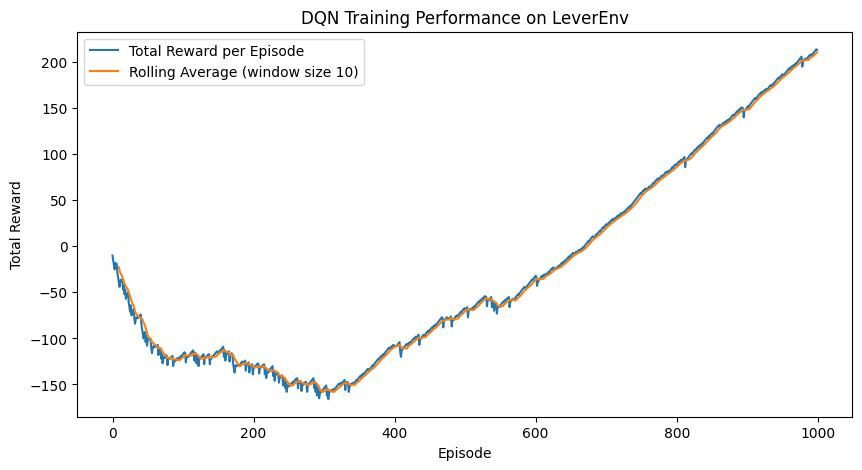

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Custom environment class LeverEnv
class LeverEnv:
    def __init__(self):
        self.state = np.array([0, 0, 0])
        self.done = False
        self.total_reward = 0

    def step(self, action):
        assert action in [0, 1, 2], "Action은 0, 1, 2 중 하나여야 합니다."
        if action == 0:
            self.state = self._pull_lever1()
        elif action == 1:
            self.state = self._pull_lever2()
        elif action == 2:
            self.state = self._pull_lever3()

        reward = self._calculate_reward()
        self.total_reward += reward
        self.done = True
        return self.state, reward, self.total_reward, self.done

    def _pull_lever1(self):
        if np.random.rand() < 0.7:
            return np.array([1, 0, 0])
        else:
            return np.array([0, 0, 0])

    def _pull_lever2(self):
        rand = np.random.rand()
        if rand < 0.1:
            return np.array([0, 1, 0])
        elif rand < 0.9:
            return np.array([0, -1, 0])
        else:
            return np.array([0, 0, 0])

    def _pull_lever3(self):
        if np.random.rand() < 0.5:
            return np.array([0, 0, -1])
        else:
            return np.array([0, 0, 0])

    def _calculate_reward(self):
        if 1 in self.state:
            return 1
        elif -1 in self.state:
            return -5
        else:
            return 0

    def reset(self):
        self.state = np.array([0, 0, 0])
        self.done = False
        return self.state

# Hyperparameters
GAMMA = 0.99
LEARNING_RATE = 0.001
BATCH_SIZE = 32
MEMORY_SIZE = 10000
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
TARGET_UPDATE_FREQUENCY = 10

# DQN network
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Memory class
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Epsilon-greedy policy
def select_action(state, policy_net, epsilon, action_dim):
    if random.random() > epsilon:
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).item()
    else:
        return random.randrange(action_dim)

# DQN optimization function
def optimize_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = list(zip(*transitions))

    states = torch.cat(batch[0])
    actions = torch.tensor(batch[1]).view(-1, 1)
    rewards = torch.tensor(batch[2], dtype=torch.float32).view(-1, 1)
    next_states = torch.cat(batch[3])
    dones = torch.tensor(batch[4], dtype=torch.float32).view(-1, 1)

    q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1)[0].view(-1, 1)
    target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

    loss = nn.functional.mse_loss(q_values, target_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Initialize environment and network
env = LeverEnv()
state_dim = len(env.state)
action_dim = 3
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_SIZE)

# Training loop
num_episodes = 1000
epsilon = EPSILON_START
all_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor([state], dtype=torch.float32)
    done = False
    total_reward = 0

    while not done:
        action = select_action(state, policy_net, epsilon, action_dim)
        next_state, reward, total_reward, done = env.step(action)
        next_state = torch.tensor([next_state], dtype=torch.float32)

        memory.push((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        optimize_model(memory, policy_net, target_net, optimizer)

    all_rewards.append(total_reward)
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    if episode % TARGET_UPDATE_FREQUENCY == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode+1}, Total Reward: {total_reward}")

# Plot results
def plot_rewards(all_rewards, window=10):
    plt.figure(figsize=(10,5))
    plt.plot(all_rewards, label='Total Reward per Episode')
    if len(all_rewards) >= window:
        rolling_mean = np.convolve(all_rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window - 1, num_episodes), rolling_mean, label='Rolling Average (window size {})'.format(window))
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN Training Performance on LeverEnv')
    plt.legend()
    plt.show()

plot_rewards(all_rewards)
